In [2]:
from pydoc import synopsis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, TensorBoard


from wordcloud import WordCloud
%matplotlib inline

### READING ANIMELIST.CSV

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
ratings_df = pd.read_csv(r"C:\Users\utkri\PycharmProjects\MLOps_Project_2\artifacts\raw\animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])

In [5]:
ratings_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
ratings_df.shape

(1048474, 3)

### DATA PROCESSING

In [7]:
n_ratings = ratings_df["user_id"].value_counts()

In [8]:
n_ratings

user_id
781     3932
890     3812
3021    3102
1397    3072
1469    2916
        ... 
449        1
2680       1
1844       1
2899       1
1866       1
Name: count, Length: 3291, dtype: int64

Out of the above users, there are also some users who have watched only 1 anime movie, so they are inexperienced users and we need to discard them.

In [9]:
# Keep only those users who have rated more than 400 movies.
rating_df = ratings_df[ratings_df["user_id"].isin(n_ratings[n_ratings>=400].index)]

In [10]:
len(rating_df)

666273

In [11]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [12]:
# Get the minimum and maximum rating
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])

In [13]:
print(f"Minimum rating is {min_rating} and maximum rating is {max_rating}")

Minimum rating is 0 and maximum rating is 10


So, range of rating goes from 0 to 10.

In [14]:
# Check for the average rating
avg_rating = np.mean(ratings_df["rating"])
print(f"Average rating is {avg_rating}")

Average rating is 4.256967745504419


We need to scale down the rating from 0 to 10 to 0 to 1. So, we use MinMax scaling.

In [15]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

C:\Users\utkri\AppData\Local\Temp\ipykernel_1532\1326829830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["rating"] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)


In [16]:
# Now check the range of average rating, min and max
min(rating_df["rating"])

0.0

In [17]:
max(rating_df["rating"])

1.0

In [18]:
np.mean(rating_df["rating"])

0.39875426439312406

So, everything is between 0 and 1.

In [19]:
# Check for duplicated values
rating_df.duplicated().sum()

0

In [20]:
# Chekc for null values
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [21]:
user_ids = rating_df["user_id"].unique().tolist()

In [22]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

In [23]:
# Printing first five user values
print(dict(list(user2user_encoded.items())[:5]))

{2: 0, 6: 1, 12: 2, 16: 3, 17: 4}


So, from above user 2 is encoded as 0, user 6 is encoded as 1 and so on.

In [24]:
# Now also get tge decoded values
user2user_decoded = {i:x for i, x in enumerate(user_ids)}

In [25]:
# Printing first five user values
print(dict(list(user2user_decoded.items())[:5]))

{0: 2, 1: 6, 2: 12, 3: 16, 4: 17}


In [26]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0.0
214,2,235,1.0
215,2,36721,0.0
216,2,40956,0.0
217,2,31933,0.0


In [27]:
# Now we need to append this encoded form in the dataframe
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

C:\Users\utkri\AppData\Local\Temp\ipykernel_1532\2542471454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [28]:
# Check for the output
rating_df.head(2)

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0


In [29]:
# Let's check how  many number of users do we have
n_users = len(user2user_encoded)
print(f"Number of experienced users are {n_users}")

Number of experienced users are 882


Now what the operations we have performed with user id, we need to do the same with anime id

In [30]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x:i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i:x for i, x in enumerate(anime_ids)}

In [31]:
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

C:\Users\utkri\AppData\Local\Temp\ipykernel_1532\54711184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)


In [32]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1


In [33]:
n_anime = len(anime2anime_encoded)
print(f"Number of unique anime movies are {n_anime}")

Number of unique anime movies are 13203


Now we want to shuffle our data. So that model learns the pattern from random data, not some sequential.

In [34]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

Now split the data into input and output features.

In [35]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [36]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [37]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [38]:
len(X_train), len(y_train), len(X_test), len(y_test)

(665273, 665273, 1000, 1000)

In [39]:
type(X_train), type(y_train), type(X_test), type(y_test)

(numpy.ndarray,
 pandas.core.series.Series,
 numpy.ndarray,
 pandas.core.series.Series)

Let's segregate the arrays into two part. First array contains information about user and second array contains information about animes.

In [40]:
X_train_array = [X_train[: , 0], X_train[: , 1]]
X_test_array = [X_test[: , 0], X_test[: , 1]]

### MODEL ARCHITECTURE

In [41]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=(1,))
    user_embedding = Embedding(
        name="user_embedding",
        input_dim=n_users,
        output_dim=embedding_size
    )(user)

    anime = Input(name="anime", shape=(1,))
    anime_embedding = Embedding(
        name="anime_embedding",
        input_dim=n_anime,
        output_dim=embedding_size
    )(anime)

    # Find the similarity between user embedding and anime embedding
    x = Dot(name="dot_product", normalize=True, axes=-1)(
        [user_embedding, anime_embedding]
    )

    # Convert high-dimensional vector to single dimension
    x = Flatten()(x)
    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)


    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["mae", "mse"]
    )

    return model


In [42]:
# Initialize the model
model = RecommenderNet()


In [43]:
# Let's check the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    112,896 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  1,689,984 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,802,886 (6.88 MB)

 Trainable params: 1,802,884 (6.88 MB)

 Non-trainable params: 2 (8.00 B)

In [44]:
# Let's define some callbacks before training the model
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

# Get the best learning rate for the model
def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs) + min_lr



In [45]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss",mode="min",
                                   save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=0, mode="min", restore_best_weights=True)

In [46]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [47]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks,
)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.7279 - mae: 0.3749 - mse: 0.1759 - val_loss: 0.6932 - val_mae: 0.3620 - val_mse: 0.1561 - learning_rate: 1.0000e-05
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.7265 - mae: 0.3743 - mse: 0.1753 - val_loss: 0.6932 - val_mae: 0.3621 - val_mse: 0.1561 - learning_rate: 1.8000e-05
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.7243 - mae: 0.3733 - mse: 0.1743 - val_loss: 0.6932 - val_mae: 0.3622 - val_mse: 0.1561 - learning_rate: 2.6000e-05
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.7213 - mae: 0.3719 - mse: 0.1729 - val_loss: 0.6934 - val_mae: 0.3623 - val_mse: 0.1562 - learning_rate: 3.4000e-05
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.7174 - mae: 0.3701 - mse: 0.1711 - val_loss: 0.6937 - val_mae: 0.3625 - val_mse: 0.1564 - learning_rate: 4.2000e-05
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.7128 - mae: 0.3679 - mse: 0.1690 - val_loss: 0.6943 - 

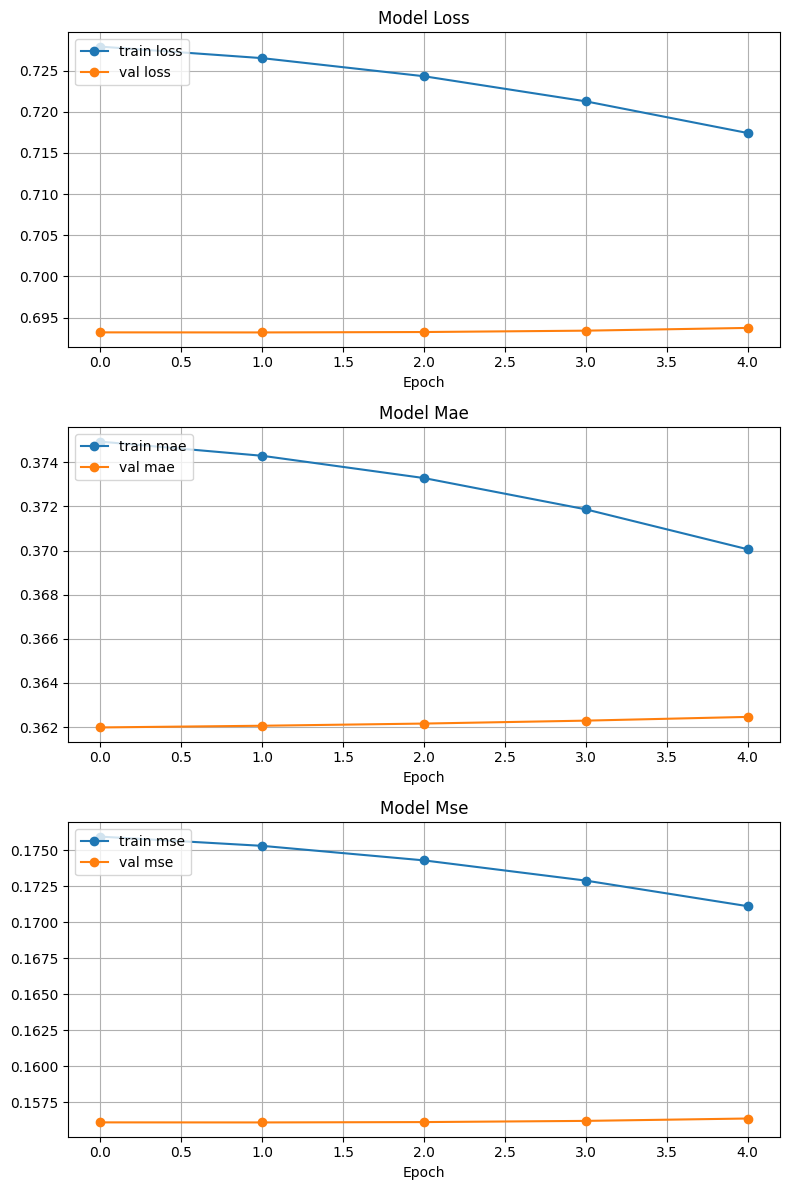

In [48]:
# Plot the loss function
metrics = ["loss", "mae", "mse"]

# Create sub-plots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"val {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

We have to extract weights from Anime and User.

In [49]:
def extract_weights(name, model):
    weights_layer = model.get_layer(name)
    weights = weights_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [50]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)

### READING ANIME.CSV

In [51]:
df = pd.read_csv(r"C:\Users\utkri\PycharmProjects\MLOps_Project_2\artifacts\raw\anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [52]:
df.replace("Unknown", np.nan, inplace=True)

In [53]:
def getAnimeName(anime_id):
    """
    This function looks up an anime’s English name from a dataframe using its ID, falls back to the original name if the English version is missing, and returns the result.
    """
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

Since `anime_id`, `eng_version` doesn't exist as a column in the dataframe, we have to define it.

In [54]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x: getAnimeName(x))

In [55]:
# Let's
getAnimeName(6702)

'Fairy Tail'

In [56]:
# Sort the dataframe in place by the Score column in descending order, placing missing values at the end using quicksort.
df.sort_values(by=["Score"], inplace=True, ascending=False, kind="quicksort", na_position="last")

In [57]:
# Let's checkout for all the columns once
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [58]:
# Select only those columns which are needed
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [59]:
# This function returns the dataframe rows for a given anime by matching either its ID (if an integer is provided) or its English name (if a string is provided).

def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [60]:
# Let's get where the data is integer
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [61]:
# Let's get where the data is string
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


### ANIME WITH SYNOPSIS

In [62]:
# Let's check for the dataframe
df_anime_syp = pd.read_csv(r"C:\Users\utkri\PycharmProjects\MLOps_Project_2\artifacts\raw\anime_with_synopsis.csv", low_memory=True)

In [63]:
df_anime_syp.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'sypnopsis'], dtype='object')

In [64]:
# So define the column names accordingly
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [65]:
# Let's rename the dataframe to soemthing shorter
synopsis_df = df_anime_syp[cols].copy()

In [66]:
synopsis_df.head(3)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."


This below function retrieves and returns an anime’s synopsis from the synopsis dataframe by matching either its MAL ID (if an integer is provided) or its name (if a string is provided).

In [67]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [68]:
# Let's check with the integer
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [69]:
# Let's check with the string
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT BASED RECOMMENDATION

In [70]:
pd.set_option("max_colwidth", None)

In [71]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)



        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]


        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })


    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [72]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Dokonjou Gaeru,0.335208,"Slice of Life, Comedy, Shounen"
8,Spring Song,0.331286,Music
7,Channel 5.5,0.323723,"Parody, Comedy"
6,D.C.S.S. ~Da Capo Second Season~,0.323530,"Comedy, Harem, Romance, Supernatural, Drama"
5,School Shock,0.313343,"Action, Sci-Fi, Comedy, Romance, Fantasy, Mecha, School"
4,Adventures On Rainbow Pond,0.312576,"Kids, Fantasy, Comedy"
3,Himitsukessha Taka no Tsume: Golden Spell,0.304944,"Comedy, Parody, Super Power"
2,Ultra Nyan: Hoshizora kara Maiorita Fushigi Neko,0.299223,"Sci-Fi, Kids"
1,Sonic X Pilot,0.293763,"Adventure, Comedy, Kids, Mecha, Sci-Fi, Shounen"
0,Bucket no Ana,0.288347,Music


### USER BASED RECOMMENDATION

In [73]:
def find_similar_users(
    item_input,
    user_weights,
    user2user_encoded,
    user2user_decoded,
    n=10,
    return_dist=False,
    neg=False
):
    try:
        # Get encoded index of the user
        encoded_index = user2user_encoded.get(item_input)
        if encoded_index is None:
            raise ValueError("User not found in encoding dictionary")

        # user_weights shape: (num_users, embedding_size)
        weights = user_weights

        # Extract target user embedding and remove extra dimensions
        target_vector = weights[encoded_index].squeeze()  # shape: (embedding_size,)

        # Compute similarity (dot product / cosine if normalized)
        dists = np.dot(weights, target_vector)  # shape: (num_users,)

        # Sort users by similarity
        sorted_dists = np.argsort(dists)

        n = n + 1  # include the user itself initially

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        # Return raw distances if requested
        if return_dist:
            return dists, closest

        # Build similarity result
        SimilarityArr = []

        for close in closest:
            decoded_id = user2user_decoded.get(close)

            SimilarityArr.append({
                "similar_users": decoded_id,
                "similarity": dists[close]
            })

        # Convert to DataFrame and clean result
        similar_users = (
            pd.DataFrame(SimilarityArr)
            .sort_values(by="similarity", ascending=False)
        )

        # Remove the input user from results
        similar_users = similar_users[similar_users.similar_users != item_input]

        return similar_users

    except Exception as e:
        print("Error Occured:", e)
        return None


In [74]:
find_similar_users(int(42),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,3331,0.280940
8,251,0.242652
7,146,0.240601
6,1582,0.225699
5,1925,0.222830
4,577,0.219025
3,2518,0.217834
2,1523,0.217681
1,1708,0.212612
0,689,0.206702


In [75]:
from collections import defaultdict

In [76]:
# Let's generate a wordcloud
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

This function below extracts and counts all genres from a dataframe, optionally visualizes their frequency using a word cloud, and returns the list of genres.

In [77]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)

    return genres_list

This function below identifies a user’s top-rated anime (based on the 75th percentile of their ratings), retrieves their genres and names, optionally visualizes genre preferences, and returns the resulting dataframe.

In [78]:
def get_user_preferences(user_id, rating_df, df, plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    #  Guard clause: no ratings for user
    if animes_watched_by_user.empty:
        print(f"No ratings found for user {user_id}")
        return None

    # Drop NaN ratings (important)
    ratings = animes_watched_by_user.rating.dropna()

    if ratings.empty:
        print(f"No valid ratings for user {user_id}")
        return None

    user_rating_percentile = np.percentile(ratings, 75)

    animes_watched_by_user = animes_watched_by_user[
        animes_watched_by_user.rating >= user_rating_percentile
    ]

    top_animes_user = (
        animes_watched_by_user
        .sort_values(by="rating", ascending=False)
        .anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot=True)

    return anime_df_rows


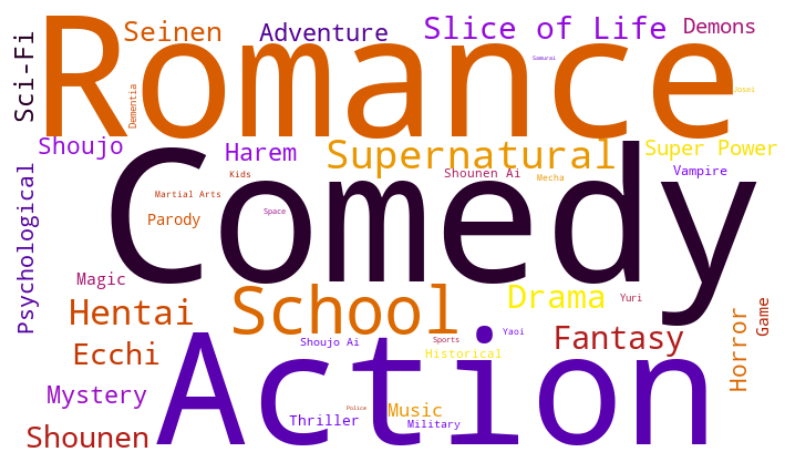

,eng_version,Genres
5683,Steins;Gate,"Thriller, Sci-Fi"
1393,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen"
7449,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
792,Nana,"Music, Slice of Life, Comedy, Drama, Romance, Shoujo"
6016,anohana:The Flower We Saw That Day,"Slice of Life, Supernatural, Drama"
...,...,...
504,Tekken:The Motion Picture,"Action, Sci-Fi, Adventure, Martial Arts"
4113,Pico to Chico,"Hentai, Yaoi"
3862,Pico x CoCo x Chico,"Hentai, Yaoi"
8058,Pupa,"Fantasy, Horror, Psychological"


In [79]:
# Plot the wordcloud
get_user_preferences(42 , rating_df, df , plot=True)

This function below generates anime recommendations by aggregating and ranking top anime preferences from similar users while excluding the current user’s favorites, and returns the top-N recommendations with genres and synopses.


In [80]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)






In [81]:
# Find users most similar to user 42 based on embedding similarity
similar_users = find_similar_users(int(42),user_weights,user2user_encoded,user2user_decoded)

In [82]:
# Retrieve top-rated anime preferences for user 42 (without plotting)
user_pref = get_user_preferences(42 , rating_df, df , plot=False)

In [83]:
# Generate top anime recommendation(s) for the user based on similar users' preferences
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,9,Digimon:The Movie,"Sci-Fi, Adventure, Comedy, Kids","This movie takes place after the Adventure series ends. It begins when a new Digimon Egg is found on the internet, and manages to penetrate into almost every computer system in Japan. When the egg hatches, it's identified as a new kind of Digimon, a Virus-type. It sustains itself by eating data from various system, and starts wreaking havok in Japan. As it consumes more and more data, it continues to evolve. And Taichi and Koushiro decide it's time to stop it. They're off, sending Agumon and Tentomon through the internet to fight off this new enemy. But, with the Virus controlling systems like the American military, all too soon, this digital menace may become all too real. Calling in the help of Yamato and Takeru, they hope that they can stop what's already begun, and maybe save this world a second time. (Source: AniDB)"


### HYBRID RECOMMENDATION SYSTEM

This function below produces a hybrid recommendation list by combining collaborative filtering (similar users) and content-based filtering (similar anime), weighted and ranked to return the top anime suggestions for a user.

In [84]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommendation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)


    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")

    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]]

In [85]:
hybrid_recommendation(42)

['Digimon:The Movie', 'Bakuman.', 'Spirited Away', 'Hunter x Hunter', 'Code Geass:Lelouch of the Rebellion', 'The Girl Who Leapt Through Time', 'One Punch Man', 'Clannad ~After Story~', 'Code Geass:Lelouch of the Rebellion R2', 'Food Wars! Shokugeki no Soma']


['Gintama:Enchousen',
 "Wooser's Hand-to-Mouth Life:Awakening Arc",
 'Digimon:The Movie',
 'Bakuman.',
 'Spirited Away',
 'Hunter x Hunter',
 'Code Geass:Lelouch of the Rebellion',
 'The Girl Who Leapt Through Time',
 'One Punch Man',
 'Clannad ~After Story~']